In [1]:
!pip install surprise

In [2]:
import json
import time
import numpy as np
import pandas as pd
from collections import defaultdict
from surprise import AlgoBase
from surprise import NormalPredictor
from surprise import PredictionImpossible
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import dump
from surprise.model_selection import cross_validate

In [3]:
start = time.time()
with open('MA_users.json', encoding="utf8") as fin:
    print('Reading',fin.name)
    user_data = json.load(fin)
end = time.time()
duration_without_dr = end-start
print("Time taken to load user data: %d seconds" %duration_without_dr)


Reading MA_users.json
Time taken to load user data: 1 seconds


In [4]:
start = time.time()
with open('MA_restaurants.json', encoding="utf8") as fin:
    print('Reading',fin.name)
    restaurant_data = json.load(fin)
end = time.time()
duration_without_dr = end-start
print("Time taken to load restaurant data: %d seconds" %duration_without_dr)

Reading MA_restaurants.json
Time taken to load restaurant data: 0 seconds


In [5]:
start = time.time()
with open('MA_reviews.json', encoding="utf8") as fin:
    print('Reading',fin.name)
    review_data = json.load(fin)
end = time.time()
duration_without_dr = end-start
print("Time taken to load review data: %d seconds" %duration_without_dr)

Reading MA_reviews.json
Time taken to load review data: 4 seconds


In [6]:
print(str(len(user_data)) + ' user records loaded')
print(str(len(review_data)) + ' review records loaded')
print(str(len(restaurant_data)) + ' business records loaded')

125521 user records loaded
914710 review records loaded
10550 business records loaded


In [7]:
print(user_data[0].keys(),'\n')
print(review_data[0].keys(),'\n')
print(restaurant_data[0].keys(),'\n')

dict_keys(['user_id', 'name', 'review_count', 'yelping_since', 'useful', 'funny', 'cool', 'elite', 'friends', 'fans', 'average_stars', 'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 'compliment_writer', 'compliment_photos']) 

dict_keys(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']) 

dict_keys(['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'attributes', 'categories', 'hours']) 



Sample User

In [8]:
user_id_dict = dict()
for i,u in enumerate(user_data):
    user_id_dict[u['user_id']] = i

def print_user_info(user_id):
    for attr in user_data[user_id_dict[user_id]].keys():
        print('{0}: {1}'.format(str(attr), str(user_data[user_id_dict[user_id]][attr]) if attr != 'friends' else '[list of user ids]'))

def get_user_attr(user_id, attribute):
    return user_data[user_id_dict[user_id]][attribute]

print_user_info('nl8gWLDo6U6MjqzbBmE_9A')

user_id: nl8gWLDo6U6MjqzbBmE_9A
name: Vivian
review_count: 1871
yelping_since: 2008-08-04 15:36:54
useful: 3624
funny: 1018
cool: 1477
elite: 2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,20,20
friends: [list of user ids]
fans: 195
average_stars: 3.57
compliment_hot: 55
compliment_more: 12
compliment_profile: 1
compliment_cute: 2
compliment_list: 10
compliment_note: 47
compliment_plain: 210
compliment_cool: 113
compliment_funny: 113
compliment_writer: 59
compliment_photos: 62


Sample review

In [9]:
for attr in review_data[0].keys():
    print('{0}: {1}'.format(str(attr), str(review_data[0][attr])))

review_id: lWC-xP3rd6obsecCYsGZRg
user_id: ak0TdVmGKo4pwqdJSTLwWw
business_id: buF9druCkbuXLX526sGELQ
stars: 4.0
useful: 3
funny: 1
cool: 1
text: Apparently Prides Osteria had a rough summer as evidenced by the almost empty dining room at 6:30 on a Friday night. However new blood in the kitchen seems to have revitalized the food from other customers recent visits. Waitstaff was warm but unobtrusive. By 8 pm or so when we left the bar was full and the dining room was much more lively than it had been. Perhaps Beverly residents prefer a later seating. 

After reading the mixed reviews of late I was a little tentative over our choice but luckily there was nothing to worry about in the food department. We started with the fried dough, burrata and prosciutto which were all lovely. Then although they don't offer half portions of pasta we each ordered the entree size and split them. We chose the tagliatelle bolognese and a four cheese filled pasta in a creamy sauce with bacon, asparagus and g

Sample business

In [10]:
business_id_dict = dict()
for i,r in enumerate(restaurant_data):
    business_id_dict[r['business_id']] = i

def print_business_info(business_id):
    for attr in restaurant_data[business_id_dict[business_id]].keys():
        print('{0}: {1}'.format(str(attr), str(restaurant_data[business_id_dict[business_id]][attr])))
        
def get_business_attr(business_id, attribute):
    return restaurant_data[business_id_dict[business_id]][attribute]
        
print_business_info('zMpWhHh6Cp1BkFRM8cbPhA')

business_id: zMpWhHh6Cp1BkFRM8cbPhA
name: Tasting Counter
address: 14 Tyler St
city: Somerville
state: MA
postal_code: 02143
latitude: 42.3817829
longitude: -71.1056689
stars: 4.5
review_count: 190
is_open: 1
attributes: {'RestaurantsPriceRange2': '4', 'RestaurantsTakeOut': 'False', 'RestaurantsDelivery': 'False', 'BusinessAcceptsCreditCards': 'True', 'OutdoorSeating': 'False', 'RestaurantsReservations': 'True', 'Alcohol': "u'beer_and_wine'", 'WiFi': "u'no'", 'BusinessAcceptsBitcoin': 'False', 'NoiseLevel': "u'average'", 'HasTV': 'False', 'RestaurantsAttire': "u'dressy'", 'Caters': 'False', 'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': True, 'valet': False}", 'DogsAllowed': 'False', 'RestaurantsTableService': 'True', 'WheelchairAccessible': 'True', 'ByAppointmentOnly': 'True', 'RestaurantsGoodForGroups': 'False', 'GoodForKids': 'False', 'BikeParking': 'True', 'GoodForMeal': "{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': True, 'brunc

Create a 2d arary of user IDs and buisness IDs, with ratings(stars) as frequencies

In [11]:
rating_mat = np.zeros((len(user_data), len(restaurant_data)))
rating_dict = {'user_id': [],
               'business_id': [],
               'rating': []}

for review in review_data:
    user_idx = user_id_dict[review['user_id']]
    business_idx = business_id_dict[review['business_id']]
    rating_mat[user_idx][business_idx] = review['stars']
    
    rating_dict['user_id'].append(review['user_id'])
    rating_dict['business_id'].append(review['business_id'])
    rating_dict['rating'].append(review['stars'])

print(rating_mat.shape)
print('number of non-zero elements(good ratings): ' +str(np.count_nonzero(rating_mat)))

(125521, 10550)
number of non-zero elements(good ratings): 879189


In [12]:
df = pd.DataFrame(rating_dict)

# filter to only the users/businesses with over 50 reviews
# necessary in order to build the anti testset
filter_user = df['user_id'].value_counts() >= 15
filter_user = filter_user[filter_user].index.tolist()

#filter_business = df['business_id'].value_counts() > 50
filter_business = df['business_id'].value_counts() >= 50
filter_business = filter_business[filter_business].index.tolist()

df_new = df[(df['user_id'].isin(filter_user)) & (df['business_id'].isin(filter_business))]

print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_new[['user_id', 'business_id', 'rating']], reader)

The original data frame shape:	(914710, 3)
The new data frame shape:	(460459, 3)


In [13]:
len(filter_business)

4260

In [14]:
# clean up some memory
#del rating_mat
del df

sim_options = {'name': 'cosine',
               'user_based': True}
trainset = data.build_full_trainset()
print(trainset.n_users)
algo = KNNWithMeans(sim_options=sim_options)

# note: this takes quite a while...
start = time.time()
algo.fit(trainset)
end = time.time()
duration_without_dr = end-start
print("Time taken to fit data: %d seconds" %duration_without_dr)
start = time.time()
#testset = trainset.build_anti_testset()
end = time.time()
duration_without_dr = end-start
print("Time taken to make antitest set: %d seconds" %duration_without_dr)
start = time.time()
#predictions = algo.test(testset)
end = time.time()
duration_without_dr = end-start
print("Time taken to predict data: %d seconds" %duration_without_dr)
#dump.dump('./predictions', predictions, algo=KNNWithMeans())
#predictions, algo = dump.load('./predictions')
#algo.fit(trainset)

14060
Computing the cosine similarity matrix...
Done computing similarity matrix.
Time taken to fit data: 42 seconds
Time taken to make antitest set: 0 seconds
Time taken to predict data: 0 seconds


In [15]:
print(trainset.global_mean)

3.7029225186172927


In [16]:
user_id = 'nl8gWLDo6U6MjqzbBmE_9A' # sample user
df_new_user = df_new.loc[df_new['user_id'] == user_id]
print(df_new_user)

                       user_id             business_id  rating
2658    nl8gWLDo6U6MjqzbBmE_9A  bU5tVs6IoXDeplQDl1QADw     4.0
2662    nl8gWLDo6U6MjqzbBmE_9A  rQ8NMRJfhTTV77gFoVYHyA     4.0
3401    nl8gWLDo6U6MjqzbBmE_9A  A5A8dP2q7_j1_jmKDjDz6w     4.0
4136    nl8gWLDo6U6MjqzbBmE_9A  tDPO_D0tjoWUOzqgRUcDkA     4.0
4674    nl8gWLDo6U6MjqzbBmE_9A  AG1ETqbneinRRJUeA8PfSA     3.0
...                        ...                     ...     ...
908614  nl8gWLDo6U6MjqzbBmE_9A  -iOW4FIS61TbvsWH-vmhEQ     4.0
909782  nl8gWLDo6U6MjqzbBmE_9A  RNqUyblZzXvg0a2fBjJQQg     3.0
910339  nl8gWLDo6U6MjqzbBmE_9A  BBblBHBnjpepOP1Q1kfi1A     3.0
912738  nl8gWLDo6U6MjqzbBmE_9A  nyy38msunExaObJOeH7j0Q     4.0
913395  nl8gWLDo6U6MjqzbBmE_9A  87f7kR7nTz8WHnmtLM_S6w     3.0

[1036 rows x 3 columns]


In [17]:
pred_list = list()
for business_id in filter_business:
    if (df_new_user['business_id'] == business_id).any():
        r_ui = df_new_user.loc[df_new_user['business_id'] == business_id, 'rating'].iloc[0]
        pred = algo.predict(user_id, business_id, r_ui = r_ui, verbose=True)
        pred_list.append(pred)
#pred = algo.predict(user_id, business_id,verbose=True)

.00   est = 3.32   {'actual_k': 40, 'was_impossible': False}
user: nl8gWLDo6U6MjqzbBmE_9A item: Uo6zk1gFwaw21YZ2gqlZCw r_ui = 4.00   est = 3.67   {'actual_k': 40, 'was_impossible': False}
user: nl8gWLDo6U6MjqzbBmE_9A item: q-Y7ep5JoBsFcPwsJsntlA r_ui = 3.00   est = 4.33   {'actual_k': 40, 'was_impossible': False}
user: nl8gWLDo6U6MjqzbBmE_9A item: 3UHLX26d_iPERGVzxfVLXQ r_ui = 4.00   est = 3.44   {'actual_k': 40, 'was_impossible': False}
user: nl8gWLDo6U6MjqzbBmE_9A item: 24k-L2B_NV5_gVSCXqkDYQ r_ui = 3.00   est = 2.81   {'actual_k': 40, 'was_impossible': False}
user: nl8gWLDo6U6MjqzbBmE_9A item: OIVAJo8QryN-bJOjOvxkVQ r_ui = 3.00   est = 2.92   {'actual_k': 40, 'was_impossible': False}
user: nl8gWLDo6U6MjqzbBmE_9A item: b0kpd0u7o8HBlrciMbGMqQ r_ui = 2.00   est = 2.82   {'actual_k': 40, 'was_impossible': False}
user: nl8gWLDo6U6MjqzbBmE_9A item: 18WftZ008z-IH_XQ1-GnlQ r_ui = 3.00   est = 4.05   {'actual_k': 40, 'was_impossible': False}
user: nl8gWLDo6U6MjqzbBmE_9A item: -rrC8RtPvvhUPcQ

In [18]:
from surprise import accuracy
accuracy.rmse(pred_list)

RMSE: 0.4759


0.47592385254800645

In [43]:
pred_list = list()
for business_id in filter_business:
    if (df_new_user['business_id'] == business_id).any():
        r_ui = df_new_user.loc[df_new_user['business_id'] == business_id, 'rating'].iloc[0]
        pred = algo.predict(user_id, business_id, r_ui = r_ui, verbose=True)
    else:
        pred = algo.predict(user_id, business_id, r_ui = 3.6767821919497012, verbose=True)
    pred_list.append(pred)
#pred = algo.predict(user_id, business_id,verbose=True)

, 'was_impossible': False}
user: nl8gWLDo6U6MjqzbBmE_9A item: -CxbIm-SqwKhXwpKV5s_uQ r_ui = 3.68   est = 2.06   {'actual_k': 14, 'was_impossible': False}
user: nl8gWLDo6U6MjqzbBmE_9A item: QF4McYH5huGxgwOC2-Rxmg r_ui = 3.68   est = 2.50   {'actual_k': 12, 'was_impossible': False}
user: nl8gWLDo6U6MjqzbBmE_9A item: 0LFo-SSHpSMDJyhHLaCPTw r_ui = 3.68   est = 2.06   {'actual_k': 7, 'was_impossible': False}
user: nl8gWLDo6U6MjqzbBmE_9A item: YyE8sPnsccZdPRZ8b_t5PQ r_ui = 3.68   est = 4.01   {'actual_k': 14, 'was_impossible': False}
user: nl8gWLDo6U6MjqzbBmE_9A item: xeE4V5ckTPktq1PgpkHanQ r_ui = 3.68   est = 1.00   {'actual_k': 6, 'was_impossible': False}
user: nl8gWLDo6U6MjqzbBmE_9A item: lE9lGJMmsjwW8XgPOV-Wlw r_ui = 3.68   est = 4.09   {'actual_k': 7, 'was_impossible': False}
user: nl8gWLDo6U6MjqzbBmE_9A item: yljfe0VbyfsvZIg-s5sXLg r_ui = 3.68   est = 2.85   {'actual_k': 10, 'was_impossible': False}
user: nl8gWLDo6U6MjqzbBmE_9A item: WBFi8tbbDBMlKoeJxWYbZg r_ui = 3.68   est = 3.00   {'

In [21]:
print_business_info('aQO6UmyhoQEY79iXikiZnQ')

business_id: aQO6UmyhoQEY79iXikiZnQ
name: Imperial Jade Gardens
address: 39 Tuttle St
city: Wakefield
state: MA
postal_code: 01880
latitude: 42.502514
longitude: -71.0761907
stars: 3.0
review_count: 17
is_open: 0
attributes: {'RestaurantsAttire': "u'casual'", 'BYOBCorkage': "'yes_free'", 'OutdoorSeating': 'False', 'RestaurantsPriceRange2': '1', 'RestaurantsGoodForGroups': 'False', 'Corkage': 'False', 'Alcohol': "u'none'", 'BusinessAcceptsCreditCards': 'True', 'RestaurantsReservations': 'False', 'Caters': 'False', 'HasTV': 'False', 'RestaurantsDelivery': 'True', 'RestaurantsTakeOut': 'True', 'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}", 'WiFi': "u'no'", 'GoodForKids': 'False', 'Ambience': "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}", 'BikeParking': 'True', 'NoiseLevel': "u'very_loud'"}
categories: Seafood, Resta

In [17]:
user_id = 'nl8gWLDo6U6MjqzbBmE_9A' # sample user

def find_topn(predictions, n, user_id):
    topn = defaultdict(list)
    for uid, bid, _, est, _ in predictions:
        topn[uid].append((bid, est))

    for uid, est in topn.items():
        est.sort(key=lambda x: x[1], reverse=True)
        topn[uid] = est[:n]

    user_results = pd.DataFrame.from_dict(topn).transpose().loc[user_id]
    
    print('Top {0} recommendations for user {1}:'.format(n, get_user_attr(user_id, 'name')))
    for i in range(n):
        print('  {0}. {1},\t{2}'.format(i+1, get_business_attr(user_results.loc[i][0], 'name'), user_results.loc[i][1]))
        
    return user_results

In [18]:
user_topn = find_topn(predictions, 5, user_id)

Top 5 recommendations for user Vivian:
  1. Java's Brewin',	4.6229184743988245
  2. Firenze Trattoria,	4.576606210260593
  3. Volo Craft Pizza,	4.537806489374372
  4. Cambridge Center Roof Garden,	4.528964445045564
  5. Polcari's Coffee,	4.4933242484679035


## Algorithm and Parameter Tuning

### Validation methods
Parameter grid search given the below error measurements:
#### Root Mean Square Error (RMSE)
* Measures standard deviation of errors in set of predictions
* Goal: minimize RMSE

#### Mean Absolute Error (MAE)
* Measures average magnitude of errors in set of predictions
* Goal: minimize MAE

In [19]:
import random
from surprise.model_selection import GridSearchCV
from surprise import accuracy


Load the full dataset

In [20]:
df = pd.DataFrame(rating_dict)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'business_id', 'rating']], reader)

Get and shuffle ratings

In [21]:
raw_ratings= data.raw_ratings
random.shuffle(raw_ratings)

Split Data (Train 80%-Test 20%)

In [22]:
split_boundary = int(.8 * len(raw_ratings))
trainset_ratings = raw_ratings[:split_boundary]
testset_ratings = raw_ratings[split_boundary:]

#set data to training_set
data.raw_ratings = trainset_ratings

Select best params/algo with Grid search

In [23]:
sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [3, 4, 5],
    "user_based": [False]
}
param_grid = {"sim_options": sim_options}

In [24]:
trainset = data.build_full_trainset()
grid_search = GridSearchCV(KNNBasic, param_grid, measures = ["rmse", "mae"], cv=3)
grid_search.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix.

In [25]:
print(grid_search.best_score["rmse"])
print(grid_search.best_params["rmse"])

print(grid_search.best_score["mae"])
print(grid_search.best_params["mae"])

1.285579546674039
{'sim_options': {'name': 'msd', 'min_support': 5, 'user_based': False}}
1.0030552349283532
{'sim_options': {'name': 'msd', 'min_support': 3, 'user_based': False}}


In [26]:
algo = grid_search.best_estimator['rmse']

In [27]:
#retrain on the whole training set
trainset = data.build_full_trainset()
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


Compute biased accuracy of training set

In [28]:
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on training set: ")
accuracy.rmse(predictions)

Biased accuracy on training set: 
RMSE: 0.6130


0.6130029633682623

Compute unbiased accuracy of the test set:

In [29]:
testset = data.construct_testset(testset_ratings)
predictions = algo.test(testset)
print("Unbiased accuracy on training set: ")
accuracy.rmse(predictions)

Unbiased accuracy on training set: 
RMSE: 1.2722


1.2721647096829234

### Repeat process with KNNWithMeans Algorithm

In [30]:
df = pd.DataFrame(rating_dict)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'business_id', 'rating']], reader)

# set data to training set
data.raw_ratings = trainset_ratings

In [31]:
from surprise import KNNWithMeans

grid_search = GridSearchCV(KNNWithMeans, param_grid, measures = ["rmse", "mae"], cv=3)
grid_search.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix.

In [32]:
print(grid_search.best_score["rmse"])
print(grid_search.best_params["rmse"])

print(grid_search.best_score["mae"])
print(grid_search.best_params["mae"])

1.2118925323685261
{'sim_options': {'name': 'cosine', 'min_support': 5, 'user_based': False}}
0.9433466597626805
{'sim_options': {'name': 'cosine', 'min_support': 3, 'user_based': False}}


In [33]:
algo = grid_search.best_estimator['rmse']

In [34]:
# retrain on the whole training set
trainset = data.build_full_trainset()
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


Compute biased accuracy of training set

In [ ]:
predictions = algo.test(trainset.build_testset())
print("Biased accuracy on training set: ")
accuracy.rmse(predictions)

Compute unbiased accuracy of test set

In [ ]:
testset = data.construct_testset(testset_ratings)
predictions = algo.test(testset)
print("Unbiased accuracy on training set: ")
accuracy.rmse(predictions)

### Parameter and Algorithm Tuning Results

Best (smallest) MAE and RMSE score for collaborative filtering on the yelp dataset use the following params:

* KNNWithMeans
* cosine similarity
* minimum support of 5? 
* not user_based

(Note to team members -I notice someone was able to run the true, if so perhaps we should integrate into the grid search above and tell me if its more efficient than false? the only thing is I wont be able to run it, so if false has a better score than perhaps we should hold off but definitely use it in our final implementation)

In [ ]:
sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [3, 4, 5],
    "user_based": [True]
}
param_grid = {"sim_options": sim_options}

grid_search = GridSearchCV(KNNBasic, param_grid, measures = ["rmse", "mae"], cv=3)
grid_search.fit(data)

5.0    293776
4.0    300725
3.0    157589
2.0     93047
1.0     69573
Name: rating, dtype: int64


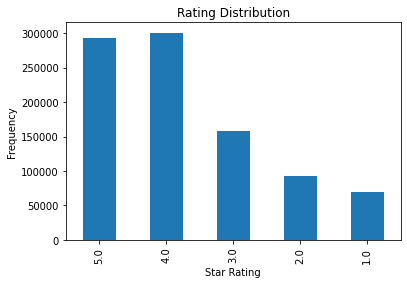

In [43]:
import matplotlib.pyplot as plt
df = pd.DataFrame(rating_dict)
print(df['rating'].value_counts().sort_index(ascending=False))
df.rating.value_counts().sort_index(ascending=False).plot(kind="bar",title='Rating Distribution',xlabel='Star Rating',ylabel="Frequency");


5.0    49880
4.0    85747
3.0    50546
2.0    20865
1.0     8653
Name: rating, dtype: int64


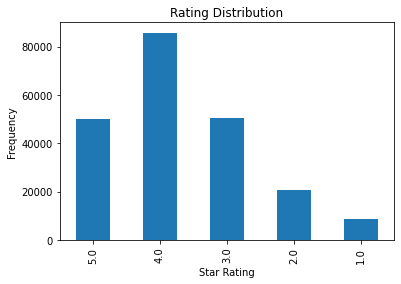

In [44]:
print(df_new['rating'].value_counts().sort_index(ascending=False))
df_new.rating.value_counts().sort_index(ascending=False).plot(kind="bar",title='Rating Distribution',xlabel='Star Rating',ylabel="Frequency");